# Classification with AdaBoost
 >__Created__:  October 08 2022 ASP 2022 South Africa, Harrison B. Prosper<br>
 >__Updated__: March 19 2023 for CLASHEP 2023, San Esteban, Chile<br>
 >__Updated__: June 28 2023 for Terascale 2023, DESY, Hamburg, Germany
 
 
Task: Use a boosted decision tree to discriminate between Higgs boson events produced via vector boson fusion from events produced via gluon gluon fusion using the di-jet mass $m_{jj}$ (massjj) and the di-jet separation $|\Delta\eta_{jj}|$ (detajj) in pseudo-rapidity. This, of course, requires events with an least two jets.

In [1]:
import os, sys
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text, plot_tree

# standard measures of model performance
from sklearn.metrics import roc_curve, auc

#import joblib as jb
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

### Load simulated HZZ4L data 

In [88]:
train = pd.read_csv('../data/hzz4l_train.csv.gz')
test  = pd.read_csv('../data/hzz4l_test.csv.gz')

# +1 for vbf, -1 for ggf
train['target'] = 2*train['target']-1
test['target']  = 2*test['target']-1

print(len(train), len(test))

train[:10]

50000 10000


,Z1mass,Z2mass,pt4l,eta4l,massjj,detajj,HT,dRZ1Z2,target
0,88.90,29.53,163.70,1.46200,64.72,0.8003,148.00,0.4661,-1.0
1,90.89,24.49,99.00,-0.04471,295.90,3.8210,106.90,0.5484,1.0
2,90.41,28.08,112.70,0.35700,167.30,0.0860,253.80,0.6925,-1.0
3,74.63,45.58,56.05,1.75200,1973.00,7.1430,118.80,0.5407,1.0
4,54.79,50.74,126.40,-0.92060,90.04,0.8111,125.50,0.2833,-1.0
5,48.77,24.68,128.80,0.75480,109.60,2.2020,88.19,2.4710,-1.0
6,78.64,17.27,112.00,1.54900,258.60,2.8240,212.10,1.0300,1.0
7,59.31,40.87,117.60,1.14600,265.10,2.8690,127.30,1.1200,-1.0
8,90.57,31.36,55.26,2.08900,201.20,3.5180,95.40,0.9355,-1.0
9,83.64,33.63,54.97,0.97770,841.50,4.9010,145.80,1.5670,1.0


In [89]:
XNAME = 'detajj'; XLABEL = r'$|\Delta\eta_{jj}|$'
YNAME = 'massjj'; YLABEL = r'$m_{jj}$ (GeV)'

XBINS =   8
XMIN  =   0
XMAX  =   8
XSTEP =   2

YBINS =   8
YMIN  =   0
YMAX  =2000
YSTEP = 500

inputs  = [XNAME, YNAME]
classes = ['GGF', 'VBF']

train_x = train[inputs]
train_y = train['target']

test_x  = test[inputs]
test_y  = test['target']

train_x[:5]

,detajj,massjj
0,0.8003,64.72
1,3.8210,295.90
2,0.0860,167.30
3,7.1430,1973.00
4,0.8111,90.04


### Approximate $p(t = +1| x)$ by histogramming

__Note__:
    
  * $x = (m_{jj}, |\Delta\eta_{jj}|)$
  * $t = 1$ for vbf events, $t = 0$ for ggf events

In [90]:
# split training data into VBF and ggF events

VBF = train['target'] > 0
sig = train[VBF]

GGF = train['target'] < 0
bkg = train[GGF]

s, xedges, yedges = np.histogram2d(sig[XNAME], sig[YNAME], 
                                   bins=(XBINS, YBINS), 
                                   range=((XMIN, XMAX), (YMIN, YMAX)))

b, xedges, yedges = np.histogram2d(bkg[XNAME], bkg[YNAME], 
                                   bins=(XBINS, YBINS), 
                                   range=((XMIN, XMAX), (YMIN, YMAX)))

# get bin centers. 
x = (xedges[:-1]+xedges[1:])/2
y = (yedges[:-1]+yedges[1:])/2

# we need a meshgrid to plot approximated probability
x, y = np.meshgrid(x, y)

# WARNING: must transpose z so that x, y, and z have the
# same shape. Also protect against s + b == 0
d = np.where(s + b <= 0, 1e10, s + b)

# approximate z = p(t=+1|data) and cache x, y, z in the 3-tuple H
z = (s / d).T
H = (x, y, z)

# choose a subset of test data to plot
K = 8000
t = test[:K]

VBF = t['target'] > 0
sig = t[VBF]

GGF = t['target'] < 0
bkg = t[GGF]

print(len(sig), len(bkg), len(sig)+len(bkg))

4021 3979 8000


### Plot contours of $p(t = 1| x) \equiv p(\text{vbf} | x)$, where $x = (|\Delta\eta_{jj}|, m_{jj})$

histogram(a, bins=10, range=None, normed=None, weights=None, density=None)

In [91]:
def plot_data(sig, bkg, h=None,
              xname=XNAME, yname=YNAME, 
              xlabel=XLABEL, ylabel=YLABEL,
              xmin=XMIN, xmax=XMAX, xstep=XSTEP,
              ymin=YMIN, ymax=YMAX, ystep=YSTEP, 
              filename='hzz4l_sig_vs_bkg.png',
              fgsize=(5, 5), 
              alpha=0.2,
              contour_colors='rainbow',
              bdt_colors='rainbow',
              ftsize=FONTSIZE, 
              bdt=None):
    
    # make room for 1 sub-plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
    
    # annotate axes
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(xlabel, fontsize=ftsize)
    ax.set_xticks(np.arange(xmin, xmax+xstep, xstep))
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=ftsize)
    ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    
    ax.scatter(sig[xname], sig[yname], marker='o',
                s=20, c='blue', alpha=alpha, label='vbf')
    ax.legend(loc='upper left') # activate legend
    
    ax.scatter(bkg[xname], bkg[yname], marker='*',
                s=10, c='red',  alpha=alpha, label='ggf')
    
    # optional add BDT bins
    if bdt:
        bdt.plot2D(itree, ax, 
                   colormap=bdt_colors, 
                   alpha=alpha)
    else:
        ax.grid()
        
    if h:
        x, y, z = h
        mylevels = np.arange(0.5, 1, 0.1) 
        
        cs = ax.contour(x, y, z, 
               extent=(xmin, xmax, ymin, ymax),
               levels=mylevels,
               linewidths=2,
               cmap=contour_colors)
    
        ax.clabel(cs, cs.levels, inline=True, 
              fontsize=20, fmt='%3.1f', 
              colors='black')
    
    ax.legend(loc='upper left') # activate legend
    
    print(filename)
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

hzz4l_detajj_massjj.png


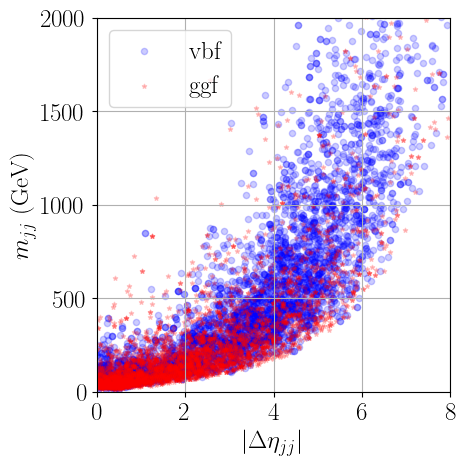

hzz4l_detajj_massjj_with_contours.png


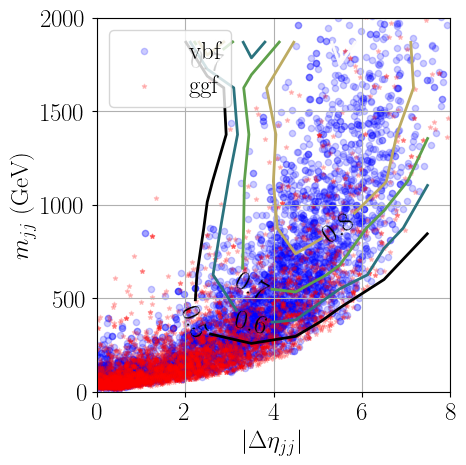

In [92]:
plot_data(sig, bkg, 
          filename='hzz4l_%s_%s.png' % (XNAME, YNAME),
          contour_colors='gist_earth')

plot_data(sig, bkg, H,
          filename='hzz4l_%s_%s_with_contours.png' % (XNAME, YNAME),
          contour_colors='gist_earth')

In [106]:
M = int(len(train_x) / 50)
M = 50

### Train boosted decision tree classifier

In [120]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                                                #min_samples_leaf=M),
                         algorithm="SAMME", 
                         n_estimators=500)

print("Training...")
bdt.fit(train_x, train_y)

print(f"Training set score: {bdt.score(train_x, train_y):10.2f}")      
print(f"Test set score:     {bdt.score(test_x,  test_y ):10.2f}")

Training...
Training set score:       0.70
Test set score:           0.69


### Load BDT wrapper class 

This Python class was adapted from one developed for TMVA many years ago.

For each leaf:
  * bweight: background fraction relative to sample size
  * sweight: signal fraction relative to sample size
  * value:   -1 or +1 for original AdaBoost algorithm


tree number 0	weight =  8.244e-01
   ROOT      massjj     310.65
  -- LEFT      massjj     111.85
  ---- LEFT      massjj      59.24
  ------ LEFT      detajj       0.82
  -------- LEFT      massjj      34.05
  ---------- LEFT  BKG   2.49e-02   4.02e-03      -1.00
  ---------- RIGHT BKG   3.76e-02   9.56e-03      -1.00
  -------- RIGHT     massjj      36.30
  ---------- LEFT  BKG   3.10e-03   1.20e-04      -1.00
  ---------- RIGHT BKG   1.61e-02   2.16e-03      -1.00
  ------ RIGHT     detajj       1.77
  -------- LEFT      massjj      86.47
  ---------- LEFT  BKG   5.18e-02   1.84e-02      -1.00
  ---------- RIGHT BKG   3.18e-02   1.65e-02      -1.00
  -------- RIGHT     massjj      80.98
  ---------- LEFT  BKG   5.08e-03   4.00e-04      -1.00
  ---------- RIGHT BKG   1.79e-02   4.42e-03      -1.00
  ---- RIGHT     massjj     204.45
  ------ LEFT      detajj       1.41
  -------- LEFT      massjj     112.85
  ---------- LEFT  SIG   3.00e-04   6.80e-04       1.00
  ---------- RIGHT BK

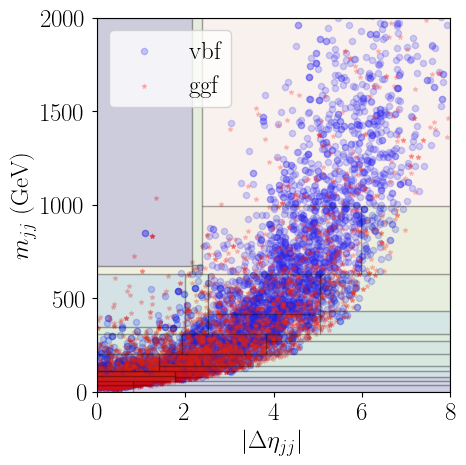

In [121]:
import bdtutil as bd
import ROOT

bdtree = bd.BDT(bdt)

itree = 0
bdtree.printTree(itree)

plot_data(sig, bkg,
          fgsize=(5, 5),
          filename='hzz4l_%s_%s_tree0.png' % (XNAME, YNAME), 
          bdt=bdtree, 
          bdt_colors='gist_earth')

In [122]:
def plot_a_tree(itree, bdt, feature_names, class_names, 
                filename='hzz4l_tree.png',
                fgsize=(6, 6),
                ftsize=FONTSIZE):
    
    # make room for 1 sub-plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
    
    artists = plot_tree(bdt.estimators_[itree], 
                        feature_names=feature_names, 
                        class_names=class_names, 
                        ax=ax,
                        proportion=True, filled=True)
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()
    return artists

In [123]:
#artists = plot_a_tree(0, bdt, feature_names=inputs, class_names=classes)

In [124]:
def plot_trees(bdt, 
               xname=XNAME, yname=YNAME, 
               xlabel=XLABEL, ylabel=YLABEL,
               xmin=XMIN, xmax=XMAX, xstep=XSTEP,
               ymin=YMIN, ymax=YMAX, ystep=YSTEP, 
               filename='hzz4l_trees.png',
               fgsize=(9, 6), 
               alpha=0.2, colormap='gist_earth',
               ftsize=FONTSIZE):
    
    # make room for 6 sub-plots
    n_rows = 2
    n_cols = 3
    fig, axs = plt.subplots(nrows=n_rows, 
                            ncols=n_cols, 
                            figsize=fgsize)
    
    kk =-1
    for ii, ax in enumerate(axs.flatten()):
        jj = ii % n_cols
        if jj == 0:
            kk += 1
            
        # annotate axes
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        
        if jj == 0:
            ax.set_ylabel(ylabel, fontsize=ftsize)
            ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
            
        if kk+1 == n_rows:
            ax.set_xlabel(xlabel, fontsize=ftsize)
            ax.set_xticks(np.arange(xmin, xmax+xstep, xstep))
    
        bdt.plot2D(ii, ax, 
                   colormap=colormap, 
                   alpha=alpha)
    
    print(filename)
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

hzz4l_trees.png


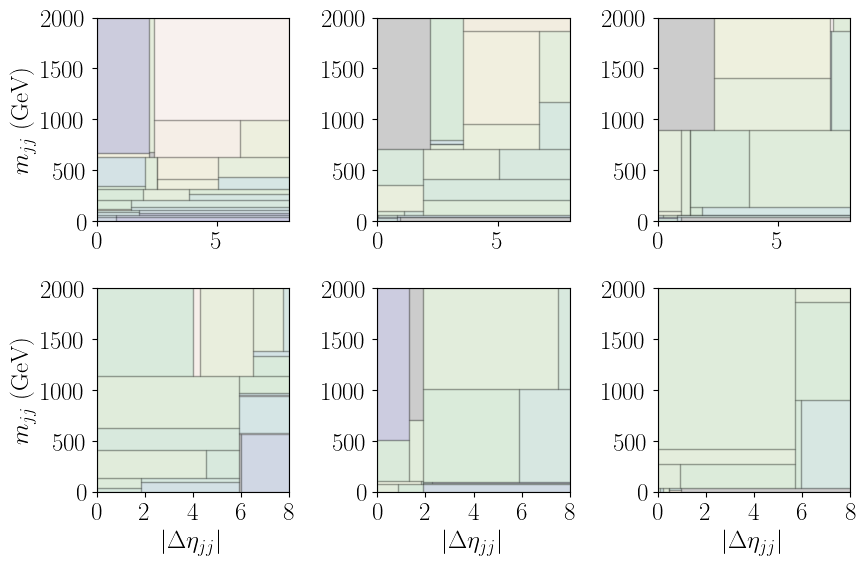

In [125]:
plot_trees(bdtree, colormap='gist_earth')

### Compare calculations between bdtree and (scikit-learn) bdt


In [127]:
x   = test_x[:10]
print(x)
print()

print('using scikit-learn definition of decision function')
print('%10s %10s\t%10s %10s' % \
      ('bdtree', 'bdt', 'bdtree(p)', 'bdt(p)'))

Y1  = bdtree.decision_function(x, like_scikit_learn=True)
P1  = bdtree.predict_proba(x, like_scikit_learn=True)

Y2  = bdt.decision_function(x)
print(Y2.shape)
P2  = bdt.predict_proba(x).T[-1]

for y1, y2, p1, p2 in zip(Y1, Y2, P1, P2):
    print('%10.5f %10.5f\t%10.5f %10.5f' % \
          (y1, y2, p1, p2))
print()
print('using correct definition of decision function')
print('%10s %10s' % ('bdtree', 'bdtree(p)'))

x   = test_x[:10]
Y1  = bdtree.decision_function(x)
P1  = bdtree.predict_proba(x)

for y1, p1 in zip(Y1, P1):
    print('%10.5f %10.5f' % (y1, p1))

   detajj  massjj
0  2.9680  208.50
1  4.6110  697.00
2  1.8730   96.73
3  2.0510  121.70
4  4.6680  452.70
5  2.8690  229.40
6  5.0940  660.50
7  1.6620   65.56
8  3.2640  415.40
9  0.5125   15.36

using scikit-learn definition of decision function
    bdtree        bdt	 bdtree(p)     bdt(p)
(10,)
  -0.00623   -0.00623	   0.49844    0.49844
   0.18826    0.18826	   0.54693    0.54693
  -0.28536   -0.28536	   0.42914    0.42914
  -0.17296   -0.17296	   0.45687    0.45687
   0.10605    0.10605	   0.52649    0.52649
  -0.00623   -0.00623	   0.49844    0.49844
   0.11740    0.11740	   0.52932    0.52932
  -0.25757   -0.25757	   0.43596    0.43596
   0.10865    0.10865	   0.52714    0.52714
  -0.19065   -0.19065	   0.45248    0.45248

using correct definition of decision function
    bdtree  bdtree(p)
  -0.04073    0.47965
   1.23105    0.92144
  -1.86598    0.02339
  -1.13099    0.09432
   0.69349    0.80011
  -0.04073    0.47965
   0.76768    0.82279
  -1.68426    0.03329
   0.71045    0

### Plot contours of constant signal probability

Even though the __AdaBoost__ algorithm is rather cryptic, it is equivalent to an algorithm that minimizes the average exponential loss, $L = \exp(-w t f / 2)$, with $w = 2$ and where the targets at $t = -1$ for ggF and $t= +1$ for VBF. Minimizing the average loss (for an infinite amount of data) requires solving

\begin{align}
    \int \frac{\partial L}{\partial f} \, p(t | x) \, dt & = 0,
\end{align}

to determine the mathematical expression approximated by the model $f(x, \omega)$ with free parameters $\omega$. When the above is solved for the exponential loss one concludes that the best fit model, $\hat{f}$ (determined with a *finite* data sample), approximates the optimal model 

\begin{align}
    f^* & = \frac{1}{2} \log \left[\frac{p(x | t = +1)}{p(x | t = -1)} \epsilon\right] ,
\end{align}

which can be rearranged as

\begin{align}
    p(t = +1 | x) & = \frac{1}{1 + \exp(-2 f^*)},\\
    & = \frac{p(x | t = +1) \, \epsilon}{p(x | t = +1) \, \epsilon + p(x | t = -1) } ,
\end{align}

where $\epsilon = \pi(t = +1) \, / \, \pi(t = -1)$ is the prior signal to background ratio, which in this example is 1.

In [63]:
def plot_contours(bdtree, sig, bkg, h=None, 
                  add_bdt_contours=False,
                  colormap='gist_earth',
                  numTrees=-1, 
                  xname=XNAME, yname=YNAME, 
                  xlabel=XLABEL, ylabel=YLABEL,
                  xmin=XMIN, xmax=XMAX, xstep=XSTEP,
                  ymin=YMIN, ymax=YMAX, ystep=YSTEP,
                  fgsize=(6, 5), 
                  alpha=0.5,
                  ftsize=FONTSIZE, 
                  filename='hzz4l_forest.png'):
    
    # make room for 1 sub-plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # annotate axes
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(xlabel, fontsize=ftsize)
    ax.set_xticks(np.arange(xmin, xmax+xstep, xstep))
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=ftsize)
    ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    
    ax.scatter(sig[xname], sig[yname], marker='o',
                s=20, c='blue', alpha=alpha, label='vbf')
    ax.legend(loc='upper left') # activate legend
    
    ax.scatter(bkg[xname], bkg[yname], marker='*',
                s=10, c='red',  alpha=alpha, label='ggF')
    ax.legend(loc='upper left') # activate legend
    
    # superimpose a BDT contour plot
    # 1. first create a meshgrid
    # 2. compute network output at all mesh points
    npoints= 100
    xdelta = float(xmax-xmin)/npoints
    ydelta = float(ymax-ymin)/npoints
    xx     = np.arange(xmin, xmax, xdelta)
    yy     = np.arange(ymin, ymax, ydelta)
    X, Y   = np.meshgrid(xx, yy)
    
    # compute model probability at every grid point
    # then reshape to an (npoints x npoints) array
    df = pd.DataFrame({xname: X.flatten(), yname: Y.flatten()})
    
    Z  = bdtree.predict_proba(df, numTrees).reshape([npoints, npoints])

    plt.imshow(Z, origin='lower', aspect='auto', 
               extent=(xmin, xmax, ymin, ymax), 
               cmap=colormap)
    
    mylevels   = [0.1, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    if add_bdt_contours:
        npoints= 10
        xdelta = float(xmax-xmin)/npoints
        ydelta = float(ymax-ymin)/npoints
        xx     = np.arange(xmin, xmax, xdelta)
        yy     = np.arange(ymin, ymax, ydelta)
        X2, Y2 = np.meshgrid(xx, yy)
        df     = pd.DataFrame({xname: X2.flatten(), 
                               yname: Y2.flatten()})
        
        Z2  = bdtree.predict_proba(df, numTrees,
                                   like_scikit_learn=False).reshape([npoints, 
                                                          npoints])

        cs = ax.contour(X2, Y2, Z2, 
               extent=(xmin, xmax, ymin, ymax),
               levels=mylevels,
               linewidths=2,
               linestyles='dashed',
               cmap='rainbow_r')
    
    if h:
        x, y, z = h
        cs = ax.contour(x, y, z, 
               extent=(xmin, xmax, ymin, ymax),
               levels=mylevels,
               linewidths=2,
                    cmap=colormap)
        ax.colorbar()
        
        ax.clabel(cs, cs.levels, inline=True, 
              fontsize=20, fmt='%3.1f', 
              colors='black')

    print(filename)
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

One sees that the boosted decision tree agrees with the probability contours approximated by histogramming.

hzz4l_forest.png


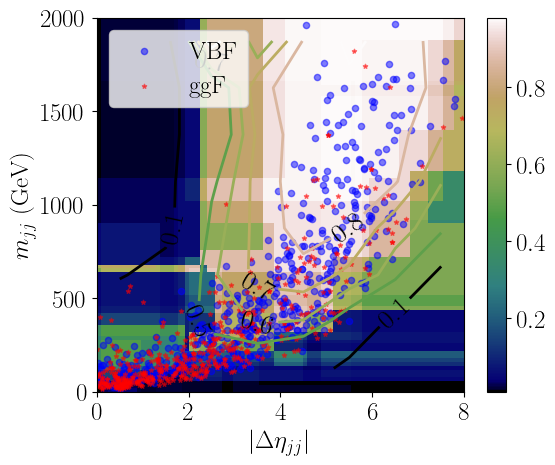

In [126]:
K = 500
ntrees = 50
plot_contours(bdtree, sig[:K], bkg[:K], h=H,
              numTrees=ntrees,
              add_bdt_contours=False,
              colormap='gist_earth')